# Backyard Bird Classifier

## 1. Business Understanding

Project FeederWatch, operated by the Cornell Lab of Ornithology and Birds Canada, is a community science program that encourages individuals across North America to monitor and report bird species visiting their feeders. The project has been running since 1987 and provides a valuable long-term dataset to scientists studying the distribution, abundance, and migration patterns of wintering bird species.

Participants submit bird counts from their homes, nature centers, schools, or community spaces using a flexible schedule between November and April. These data have been used in numerous scientific studies, revealing trends in species ranges, population shifts, and feeder use. However, because observations are made by people of all skill levels—many of them amateur birders—identification errors are common. This introduces noise into the dataset, potentially obscuring long-term trends and biological signals.

To mitigate this limitation, this project proposes a computer vision approach to improve the consistency and accuracy of bird species identification from images. By training a machine learning model to classify feeder birds, we can provide an automated or semi-automated tool to assist human observers and validate their reports.

Cornell’s NABirds dataset contains over 48,000 annotated images of 555 bird species commonly observed in North America. This project will subset that dataset using Cornell’s list of the 100 most common feeder birds and train a deep learning model to recognize them from photographs. The long-term goal is to support systems that can automatically identify feeder birds from camera traps or assist FeederWatch participants in double-checking their own identifications.

### Objective

Build and evaluate an image classification model that can:

- Automatically identify bird species from a curated list of the 100 most common feeder birds
- Achieve greater than 80% overall classification accuracy
- Provide per-class metrics such as precision, recall, and F1-score to assess individual species performance
- Incorporate interpretability tools (e.g., LIME and Grad-CAM) to explain model predictions
- Be exportable to lightweight formats (e.g., ONNX) for deployment on edge devices like the Raspberry Pi

### Data Sources

- NABirds Dataset: [https://dl.allaboutbirds.org/nabirds](https://dl.allaboutbirds.org/nabirds)
- FeederWatch Program: [https://feederwatch.org](https://feederwatch.org)
- 100 Common Feeder Birds: [https://feederwatch.org/learn/common-feeder-birds/](https://feederwatch.org/learn/common-feeder-birds/)

### Data Understanding

#### Dataset Access

This notebook uses a public subset of the NABirds dataset hosted on Kaggle:

**Dataset:** [Backyard Feeder Birds (NABirds Subset)](https://www.kaggle.com/datasets/jakemccaig/backyard-feeder-birds-nabirds-subset)  
**Owner:** [jakemccaig](https://www.kaggle.com/jakemccaig)  
**Structure:** ImageNet-style `train/`, `val/`, and `class_labels.txt`


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Define base paths
base_path = "./backyard_birds_dataset"
train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "val")

# Load class folders
class_names = sorted(os.listdir(train_path))

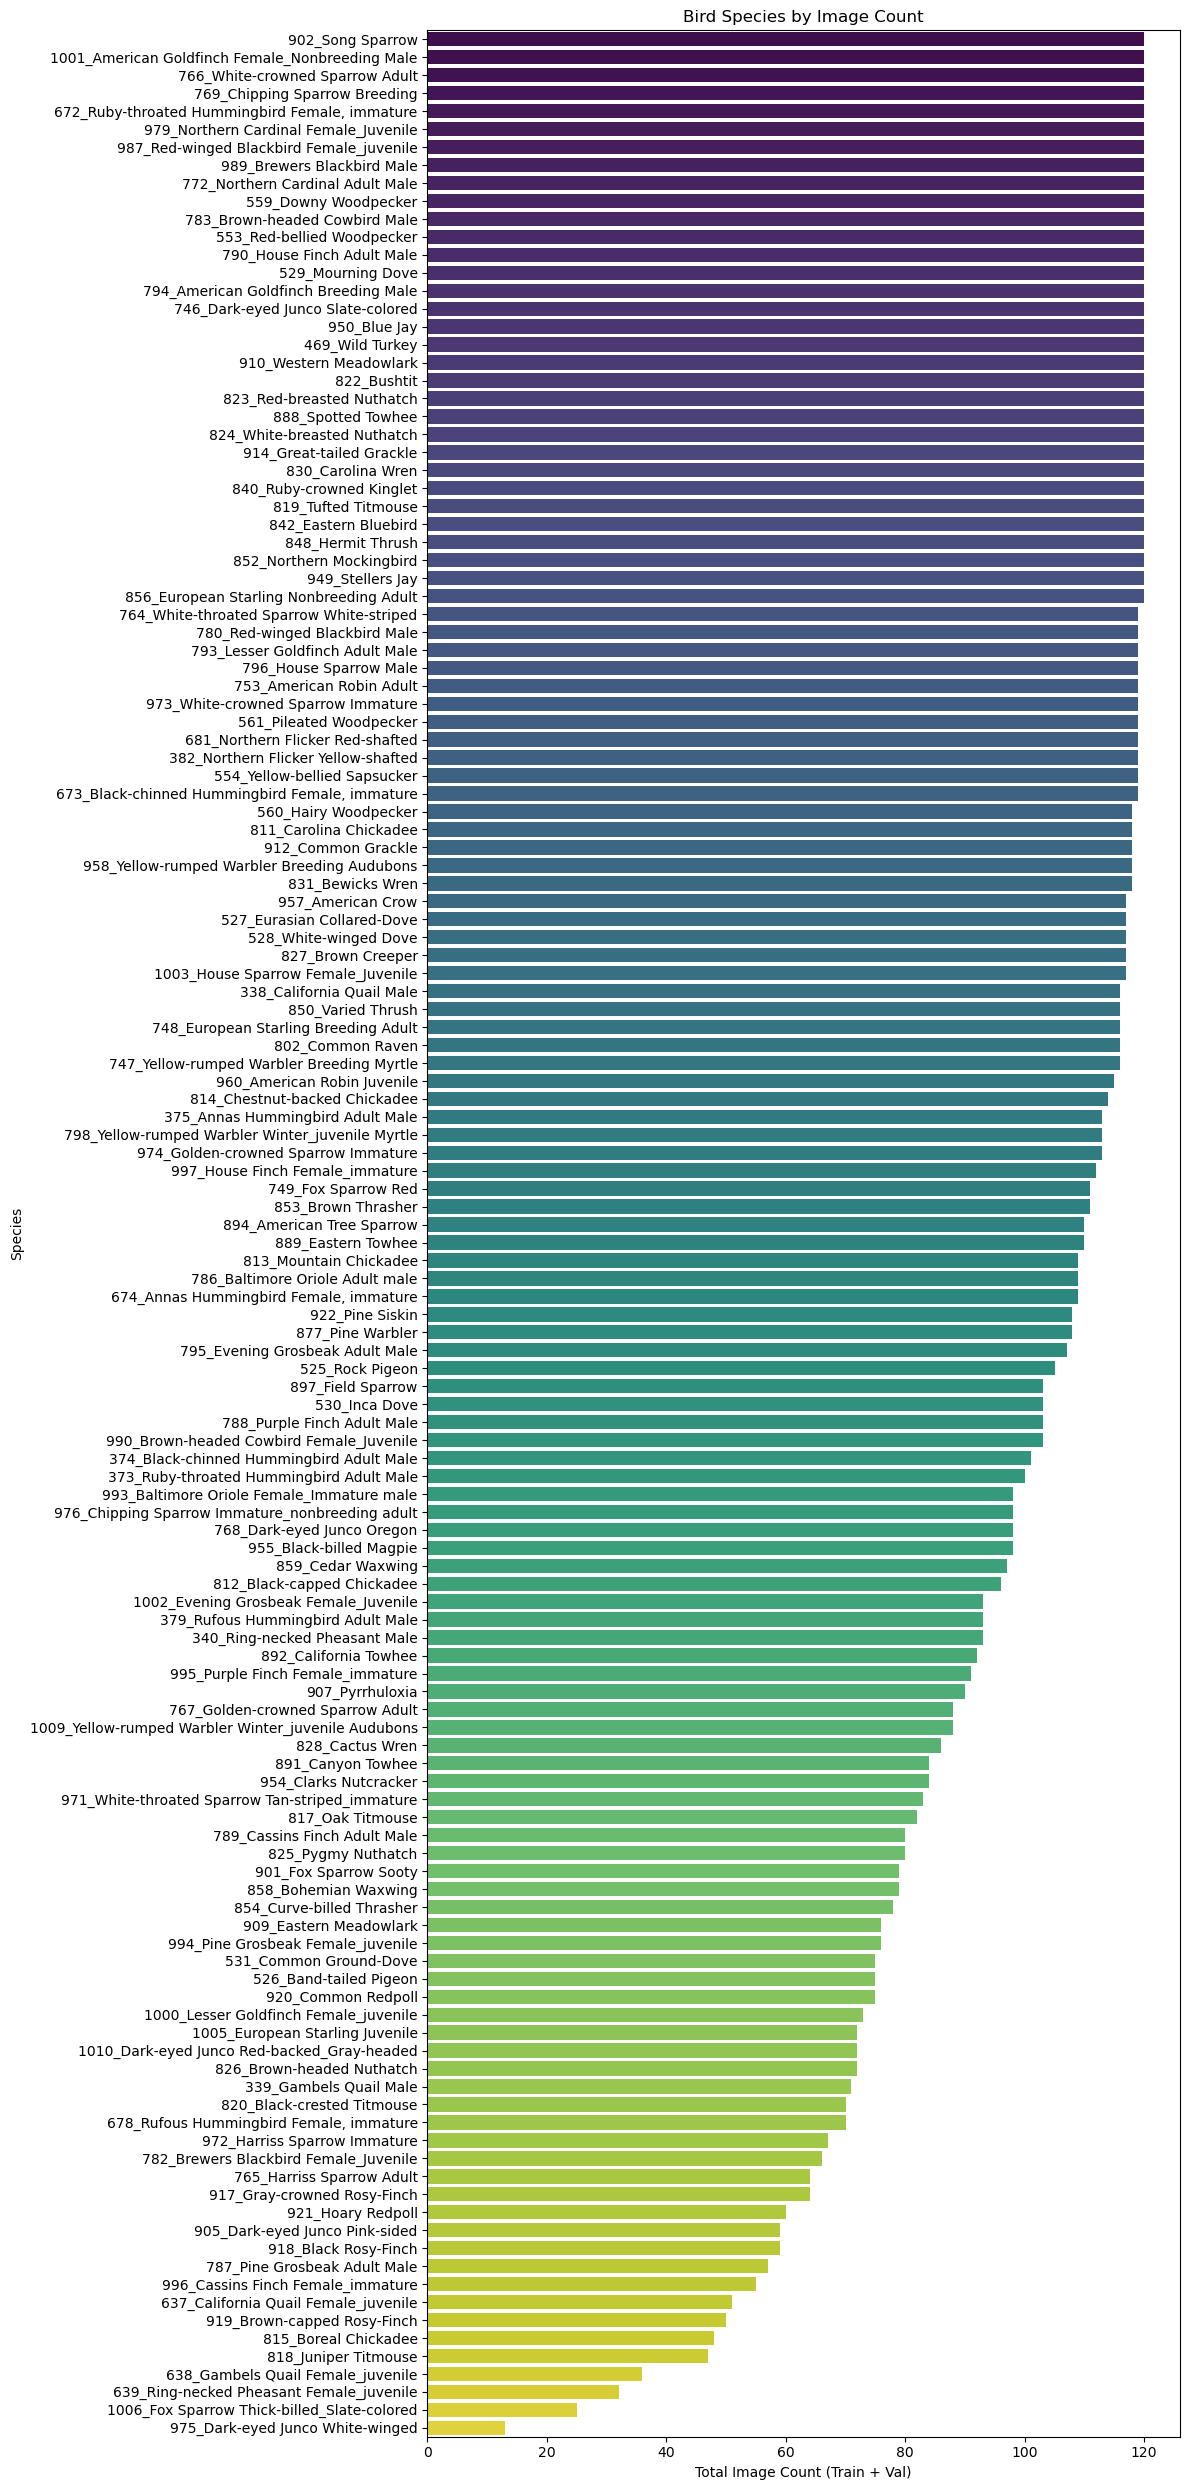

In [17]:
# Visualize image counts per class
class_names = sorted([
    d for d in os.listdir(train_path)
    if os.path.isdir(os.path.join(train_path, d))
])

# Count images per class
train_counts = {cls: len(os.listdir(os.path.join(train_path, cls))) for cls in class_names}
val_counts = {cls: len(os.listdir(os.path.join(val_path, cls))) for cls in class_names}

# Combine into dataframe
df_counts = pd.DataFrame({
    "Class": class_names,
    "Train Count": [train_counts[cls] for cls in class_names],
    "Val Count": [val_counts[cls] for cls in class_names]
})
df_counts["Total"] = df_counts["Train Count"] + df_counts["Val Count"]
df_counts = df_counts.sort_values("Total", ascending=False)

# Plot top 30
plt.figure(figsize=(12, 25))
sns.barplot(
    data=df_counts.head(134),
    x="Total", y="Class", hue="Class", palette="viridis", legend=False
)
plt.title("Bird Species by Image Count")
plt.xlabel("Total Image Count (Train + Val)")
plt.ylabel("Species")
plt.tight_layout()
plt.show()

### Data Prep/Cleaning

### Modeling

### Evaluation/Interpretability

### Deployment